### Temporal Dataset Analysis of Illumina Amplicon Sequencing Data

This notebook analyzes Illumina sequencing data using BLAST-based alignment.

The region of interest was divided into four sections, which are merged prior to visualization.

Mutation enrichments for each dataset have already been computed using the scripts:
- `0_Illumina_preprocess_and_align_reads.py` – for read preprocessing and BLAST alignment  
- `1_Illumina_analyze_mutation_enrichment.py` – for calculating mutation enrichment across the regions of interest

For more details, see the `README.md` file in this repository.

---

In the sections below, we perform focused analyses and generate visual summaries, including:
- Merging mutation data across sections  
- Visualizing mutation enrichment across timepoints or replicates  

---

In [1]:
# --- Import necessary modules ---
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import yaml
import json
from importlib import reload
from plotting import *
import functions_

import matplotlib.pyplot as plt
import matplotlib as mpl


# ## reload the evaluation functions
# import plotting
# reload(plotting)


# reload(functions_)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

In [2]:
# ======================== CONFIGURATION ========================

# --- Define annotated amino acid sequence for AraC-LOV2 fusion ---
AraC_LOV2_annot = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293', '*294']
data_type = "AA" 
data_folder = "data/Illumina/POGO/"

# --- Define POGO cycles ---

cycles = ["Mut1", "Neg1", "Pos1", "Mut2", "Neg2", "Pos2","Mut3", "Neg3", "Pos3"]

FigFolder = None #"output/POGO/blast/combined_plots/" ## define the folder for the output figures


# ======================== LOAD CONFIG AND AMPLICON ========================

# --- Load configuration file containing amplicon sequence and primer information ---
with open(data_folder+"config.json") as file: 
    POGO_config = json.load(file)

# --- Extract amplicon and correct for frame offset using primer info ---
amplicon = POGO_config["amplicon"][POGO_config["Primer_out_of_triplets"]["S1_fwd"]:] 
amplicon_AA = translate_dna2aa(amplicon)

# --- Set index step size (1 for DNA, 3 for AA due to codon translation) ---
idx_steps = 1 if data_type != "AA" else 3

# --- Define start and end sequences of AraC in DNA ---
AraC_start = "ATGTCCGAGGA"
AraC_end = "AGCGGGTAA"

# --- Find indices of the AraC-LOV2 region within the amplicon ---
AraC_start_idx = amplicon.index(AraC_start)//idx_steps
AraC_end_idx = (amplicon.index(AraC_end)+len(AraC_end))//idx_steps

# --- Extract reference sequence for AraC-LOV2 (DNA or AA depending on setting) ---
AraCLOV2_ref = amplicon[AraC_start_idx:AraC_end_idx] if data_type != "AA" else amplicon_AA[AraC_start_idx:AraC_end_idx]

# --- Store total amplicon length depending on data type ---
amplicon_len = len(amplicon) if data_type == "DNA" else len(amplicon_AA)

In [8]:
# ======================== DETECT AVAILABLE NGS RUNS ========================
NGS_runs= [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]
print(NGS_runs)

['NegPos_C2', 'Mut_C1C3', 'Mut_C2', 'Mut_C1C2C3_S2S3_rep1', 'Mut_C1C2C3_S2S3_rep2', 'NegPos_C1C3', 'NegPos_C1C2C3_S2S3_rep1', 'NegPos_C1C2C3_S2S3_rep2']


In [4]:
# --- Assign correct POGO cycle annotation to each barcode (Bc) for every NGS run ---

Barcodes = dict(Mut_C1C3 =  {"BC1": "Mut1", 
                            "BC2" : "Mut3"},

                NegPos_C1C3 = {"BC1": "Neg1",
                                "BC2": "Pos1", 
                                "BC3": "Neg3", 
                                "BC4": "Pos3"},

                Mut_C2  = {"BC1": "Mut2"},

                NegPos_C2 = {"BC1": "Neg2",
                            "BC2": "Pos2"},
                            
                NegPos_C1C2C3_S2S3_rep1 = {"BC1": "Neg1", 
                "BC2": "Pos1", 
                "BC3": "Neg2", 
                "BC4": "Pos2", 
                "BC5": "Neg3", 
                "BC6": "Pos3"
                },
                            
                NegPos_C1C2C3_S2S3_rep2 = {"BC1": "Neg1", 
                "BC2": "Pos1", 
                "BC3": "Neg2", 
                "BC4": "Pos2", 
                "BC5": "Neg3", 
                "BC6": "Pos3"
                }, 
                
                Mut_C1C2C3_S2S3_rep2 = {"BC1": "Mut1", 
                     "BC2": "Mut2",
                     "BC3": "Mut3"},
                                        
                Mut_C1C2C3_S2S3_rep1 = {"BC1": "Mut1", 
                     "BC2": "Mut2",
                     "BC3": "Mut3"}                       
)

In [ ]:
# ======================== INITIALIZE ENRICHMENT MATRICES ========================
enrichments = pd.DataFrame(columns = [str(x) for x in list(range(amplicon_len))], index = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '*'], data = 0, dtype = np.float64)

# --- Initialize enrichment and coverage dictionaries per cycle ---
all_enrichments = {key: enrichments.copy() for key in cycles}
all_coverages = {key: enrichments.copy() for key in cycles}

# ======================== LOAD ENRICHMENTS PER RUN AND BARCODE ========================

# --- Iterate over each NGS run directory ---
for ngs_run in NGS_runs:
    print(ngs_run)
    used_Barcodes = Barcodes[ngs_run].keys()
    # --- Load config file for current NGS run (defines 'Sections') ---
    with open("data/fastq/POGO/" + ngs_run + "/config.json", "r") as file:
        ngs_config = json.load(file)
    Sections = ngs_config["Sections"]
    for Bc in used_Barcodes: 
        for Section in Sections: 
            variant_name = f"{ngs_run}_{Bc}_{Section}_combined_roiFalse_{data_type}"
            # --- Load precomputed enrichment table for the given variant ---
            enrichment = pd.read_csv(f"output/Illumina/POGO/blast/enrichments/{ngs_run}/{variant_name}_all_variants.csv", index_col = 0)
            # --- Extract position columns and assign corresponding cycle ---
            columns = list(enrichment.columns)
            cycle = Barcodes[ngs_run][Bc]
            print(ngs_run, Bc, cycle)
            # --- Add enrichment values to the cumulative matrix for that cycle ---
            all_enrichments[cycle].loc[:,columns] += enrichment


NegPos_C2


FileNotFoundError: [Errno 2] No such file or directory: 'data/fastq/POGO/NegPos_C2/config.json'

NegPos_C2


FileNotFoundError: [Errno 2] No such file or directory: 'data/Illumina/POGO/blast/enrichments/NegPos_C2/NegPos_C2_BC1_S1_combined_roiFalse_AA_all_variants.csv'

In [9]:
##combine enrichments for all cycles
combined_enrichments = {}

for cyclename, cycle_enrichment in all_enrichments.items():

    cycle_enrichment.columns = [int(x) for x in cycle_enrichment.columns]
    combined_enrichments[cyclename] = {}

    combined_enrichments[cyclename]["coverage"] = pd.DataFrame(cycle_enrichment.sum(axis = 0)[AraC_start_idx:AraC_end_idx]).T

    counts, relative_freq = mask_ref_in_variants_df(cycle_enrichment, ref_seq = amplicon_AA if data_type == "AA" else amplicon, data_type = data_type)
    
    combined_enrichments[cyclename]["mut_enrichment"]= [counts.iloc[:,AraC_start_idx:AraC_end_idx], relative_freq.iloc[:,AraC_start_idx:AraC_end_idx]]


NameError: name 'all_enrichments' is not defined

## Visualization 
### Complete sequence 

In [21]:
## reload the evaluation functions
from importlib import reload 
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *

colors = [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

# Create the colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)

coverage_cmap = mcolors.LinearSegmentedColormap.from_list("grey_custom", ["black", "lightgrey"], N=256)


In [22]:
plot_temporal_enrichment(combined_enrichments, ref = AraC_LOV2_annot, vmax=0.1, show_cbar_for_each = False, plt_titles = None, show_plttitles = False, plot_coverage = True, bias_per_pos = None, show_only_pos = None, return_df = False, FigFolder = FigFolder, figsize = (30,15), data_type = "AA", enrichment_cmap = custom_cmap, set_over_color= "Yellow", coverage_cmap=coverage_cmap)

NameError: name 'AraC_LOV2_annot' is not defined

### Show only highly enriched positons

In [23]:
cov_filter_treshold = 50
mut_rate_filter_treshold = 0.03

high_mut_positions = []
low_cov_positions = []

for cyclename, sample_data in combined_enrichments.items():
    variant_relative_freq = pd.DataFrame(sample_data["mut_enrichment"][1].sum(axis=0)).T

    coverages = sample_data["coverage"]
    ## find pos with high mutation rate and low coverage
    low_cov_pos = [idx for idx, cov in enumerate(coverages) if cov < cov_filter_treshold]
    high_mut_pos = [idx for idx, mut_rate in enumerate(variant_relative_freq.values[0]) if mut_rate > mut_rate_filter_treshold]

    low_cov_positions.extend(low_cov_pos)
    high_mut_positions.extend(high_mut_pos)

## order dict values
all_high_mut_positions = list(sorted(set([idx for idx in high_mut_positions if idx not in low_cov_positions])))

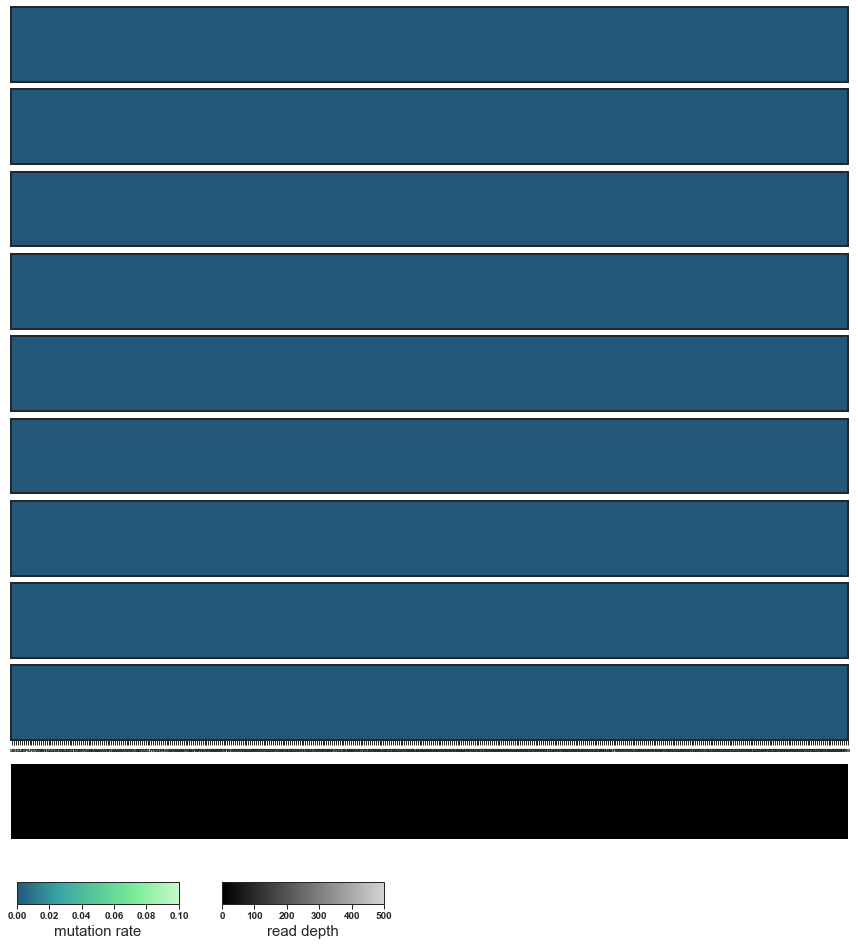

In [27]:
plot_temporal_enrichment(combined_enrichments, ref = AraC_LOV2_annot, vmax=0.1, show_cbar_for_each = False, plt_titles = None, show_plttitles = False, plot_coverage = True, bias_per_pos = None, show_only_pos = all_high_mut_positions, return_df = False, FigFolder = FigFolder, figsize = (15,15), data_type = "AA", enrichment_cmap = custom_cmap, set_over_color= "Yellow", coverage_cmap=coverage_cmap)

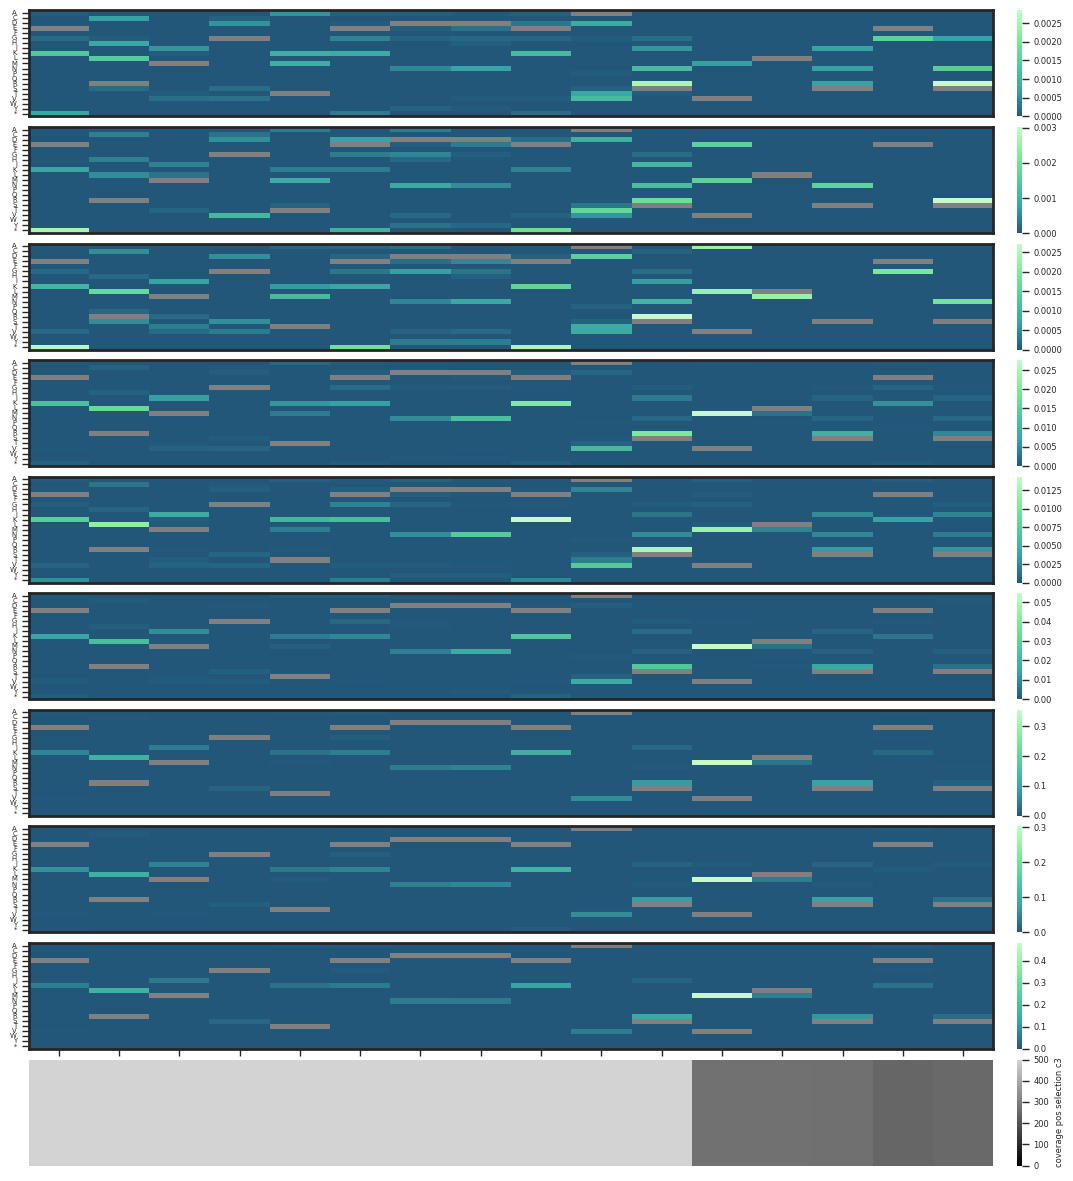

In [30]:
plot_temporal_enrichment(combined_enrichments, ref = AraC_LOV2_annot, combine_mut_rates=False, vmax = None,show_cbar_for_each = True, plt_titles = cycles, show_plttitles = False, plot_coverage = True, bias_per_pos = None, show_only_pos = all_high_mut_positions, return_df = False,  figsize = (15,15), data_type = "AA", FigFolder = FigFolder,  enrichment_cmap = custom_cmap, set_over_color= "Yellow", coverage_cmap=coverage_cmap)